# Assignment 2

**Deadline**:  01/10/2024, 17.00

**Names and student numbers:**
1. name (student number)
2. ...
3. ...

**Declaration of Originality**

We whose names are given under 1., 2. and 3. above declare that:
1. These solutions are solely our own work.
2. We have not made (part of) these solutions available to any other student.

## Instructions for completing and submitting the assignment
Please pay attention to the following instructions:
1. Please follow carefully the steps outlined in the assignment. If you cannot solve an exercise and this hinders continuing with subsequent exercises, try to find a way to work around it and give a clear explanation for the solution you have chosen.
2. Submit your work in the form of a Jupyter notebook via Canvas, before the deadline. Your notebook should not give errors when executed with `Run All`.
4. You are allowed to work on the assignment in groups of 2 or 3 students and to submit together. Before you submit, you and your team members have to register as an **Assignments group** on Canvas. Only a single member of each group has to submit the notebook. Please do **NOT** submit the same notebook multiple times!
5. Please write your names also inside this markdown cell, under **Names and student numbers**.

# IMPORTANT: RESTRICTION ON ALLOWED LIBRARIES!!!
You are **NOT** allowed to use any scikit-learn models and functions, except `Kfold` (possibly needed in part 2) and `datasets` (needed in part 2). Material from the computer classes, including the solutions, can be used and copied freely and without penalty.

## Part 0: importing the relevant libraries

**Exercise 1:** import all the libraries you are using in this notebook.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn import datasets

**Auxiliary functions:** you will need the functions in the cell below to run the notebook. Do not change these functions at any time!!!

In [29]:
def contour_plot_bivariate_Gaussian(subplot, mu = np.array([0., 0.]), Sigma = np.eye(2)):
    
    # Our 2-dimensional distribution will be over variables X and Y
    N = 40
    X = np.linspace(-2, 2, N)
    Y = np.linspace(-2, 2, N)
    X, Y = np.meshgrid(X, Y)

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    def multivariate_gaussian(pos, mu, Sigma):
        """Return the multivariate Gaussian distribution on array pos."""

        n = mu.shape[0]
        Sigma_det = np.linalg.det(Sigma)
        Sigma_inv = np.linalg.inv(Sigma)
        N = np.sqrt((2*np.pi)**n * Sigma_det)
        # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
        # way across all the input variables.
        fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

        return np.exp(-fac / 2) / N

    # The distribution on the variables X, Y packed into pos.
    Z = multivariate_gaussian(pos, mu, Sigma)
    
    subplot.contourf(X, Y, Z, cmap=cm.viridis) 

## Part 1: Bayesian learning
Recall the polynomial regression model with Gaussian noise. Given is a set of N datapoints $\mathcal{D}_N = \{ (x_n, y_n) \}_{n=1}^N,$ which are assumed to be modeled by a mean plus Gaussian noise:
$$
y = f(x, \vec{\beta}) + \epsilon, \qquad \epsilon \thicksim \mathcal{N}(0,\sigma^2),
$$
where $f(x, \vec{\beta}) =\vec{\beta} \cdot \vec{\phi}(x)$ with polynomial basis functions $\phi_i(x) = x^i$ for $i=0,1,2, \ldots, M.$

In the Bayesian learning approach for the model parameters $\vec{\beta},$ we define a prior
$$ \vec{\beta} \thicksim \mathcal{N} (\vec{0}, \sigma_0^2 I).$$
Combined with the Gaussian likelihood coming from the model assumptions, it is possible to derive the following posterior:
$$
\vec{\beta} |\mathcal{D}_N \thicksim \mathcal{N} \left( \vec{\mu}_N, {\bf S}_N  \right),
$$
where the posterior mean is given by
$$
\vec{\mu}_N = \frac{1}{\sigma^2} {\bf S}_N {\bf X}^T \vec{y},
$$
with
$$
{\bf X} = \left(
\begin{matrix}
\phi_0 (x_1) & \cdots & \phi_M (x_1) \\
\phi_0 (x_2) & \cdots & \phi_M (x_2) \\
\vdots & \vdots & \vdots \\
\phi_0 (x_N) & \cdots & \phi_M (x_N)
\end{matrix}
\right), \qquad \vec{y} = \left(
\begin{matrix}
y_1 \\
y_2 \\
\vdots \\
y_N
\end{matrix}
\right),
$$
and with a posterior variance-covariance matrix ${\bf S}_N$ speficied by
$$
\left({\bf S}_N\right)^{-1} = \frac{1}{\sigma_0^2}I + \frac{1}{\sigma^2} {\bf X}^T {\bf X}.
$$
In the following exercise, we will apply the Bayesian learning approach to the data that is imported and plotted in the cell below.

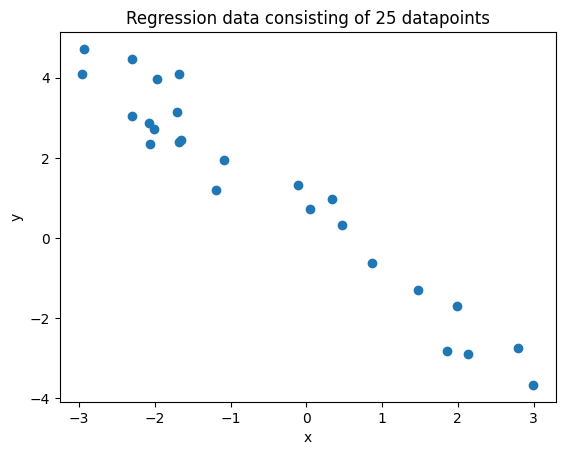

In [30]:
data = np.loadtxt("DSM_assignment2_data_Bayes.csv")
X = data[:,0]
Y = data[:,1]
N = len(X)

fig, ax = plt.subplots()

ax.scatter(X, Y)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Regression data consisting of {} datapoints".format(N));

**Exercise 2:** The formulas above describe the Bayesian learning approach for a dataset of a fixed size. In practice however, data often becomes available sequentially (e.g. real-time monitoring of patients). The goal of this exercise is to implement a sequential version of the Bayesian learning approach as the size of the dataset grows. The full dataset is stored in `X` (input feature) and `Y` (target variable). Suppose that initially the first $N' - 1 \, ( \leq N-1)$ datapoints are available. If we then observe the $N'$-th datapoint, we can update the posterior by multiplying the likelihood of the $N'$-th observation with the prior based on the first $N'-1$ observations. This prior corresponds to the posterior of the previous iteration.

We will do this for different sizes of the dataset $\mathcal{D}_{N'} = \{ (x_n, y_n) \}_{n=1}^{N'},$ where the size of the dataset can take values $N' = 1, 2, 3, 4, 8, 16$ and $25 (=N).$ A dataset of size $N'$ is created by simply taking the first $N'$ observations of the full dataset of size $N=25,$ which was imported in the cell above.

In this exercise, we restrict ourselves to linear regression models ($M=1$) and we will assume that $\sigma=\sigma_0 = 1.0$ are both known.

Given a dataset $\mathcal{D}_{N'} = \{ (x_n, y_n) \}_{n=1}^{N'}$ of size $N',$ you need to do the following:
* compute the parameters of the prior based on the first $N' - 1$ datapoints in the dataset.
* compute the parameters of the posterior based on the first $N'$ datapoints in the dataset.
* create 2-dimensional density plots of both the prior and posterior.
* plot 5 fits of the model, based on parameters randomly drawn from the posterior.

In the cell below, we helped you by giving you the template of the required plots. The priors and posteriors plotted in the template are all bivariate standard normal distributions. The 5 plotted fits through the data are simply linear functions with slope 1 and differing intercepts. It is your task to produce the correct priors, posteriors and fits.

In [31]:
def get_columns_of_ones(X: np.ndarray) -> np.ndarray:
    """Add a column of ones to the beginning of input matrix X."""
    return np.c_[np.ones(X.shape[0]), X]

def compute_parameters(X: np.ndarray, y: np.ndarray, sigma_zero: float = 1.0, sigma: float = 1.0):
    # Add a column of ones to X
    X = get_columns_of_ones(X)

    # Calculate S_n inverse
    S_n_inverse = (1/sigma_zero) * np.eye(2) + (1/sigma) * X.T @ X
    # The inverse of the inverse is the matrix itself
    S_n = np.linalg.inv(S_n_inverse)
    # Calculate mu_n
    mu_n = (1/sigma) * S_n @ X.T @ y
    return mu_n, S_n

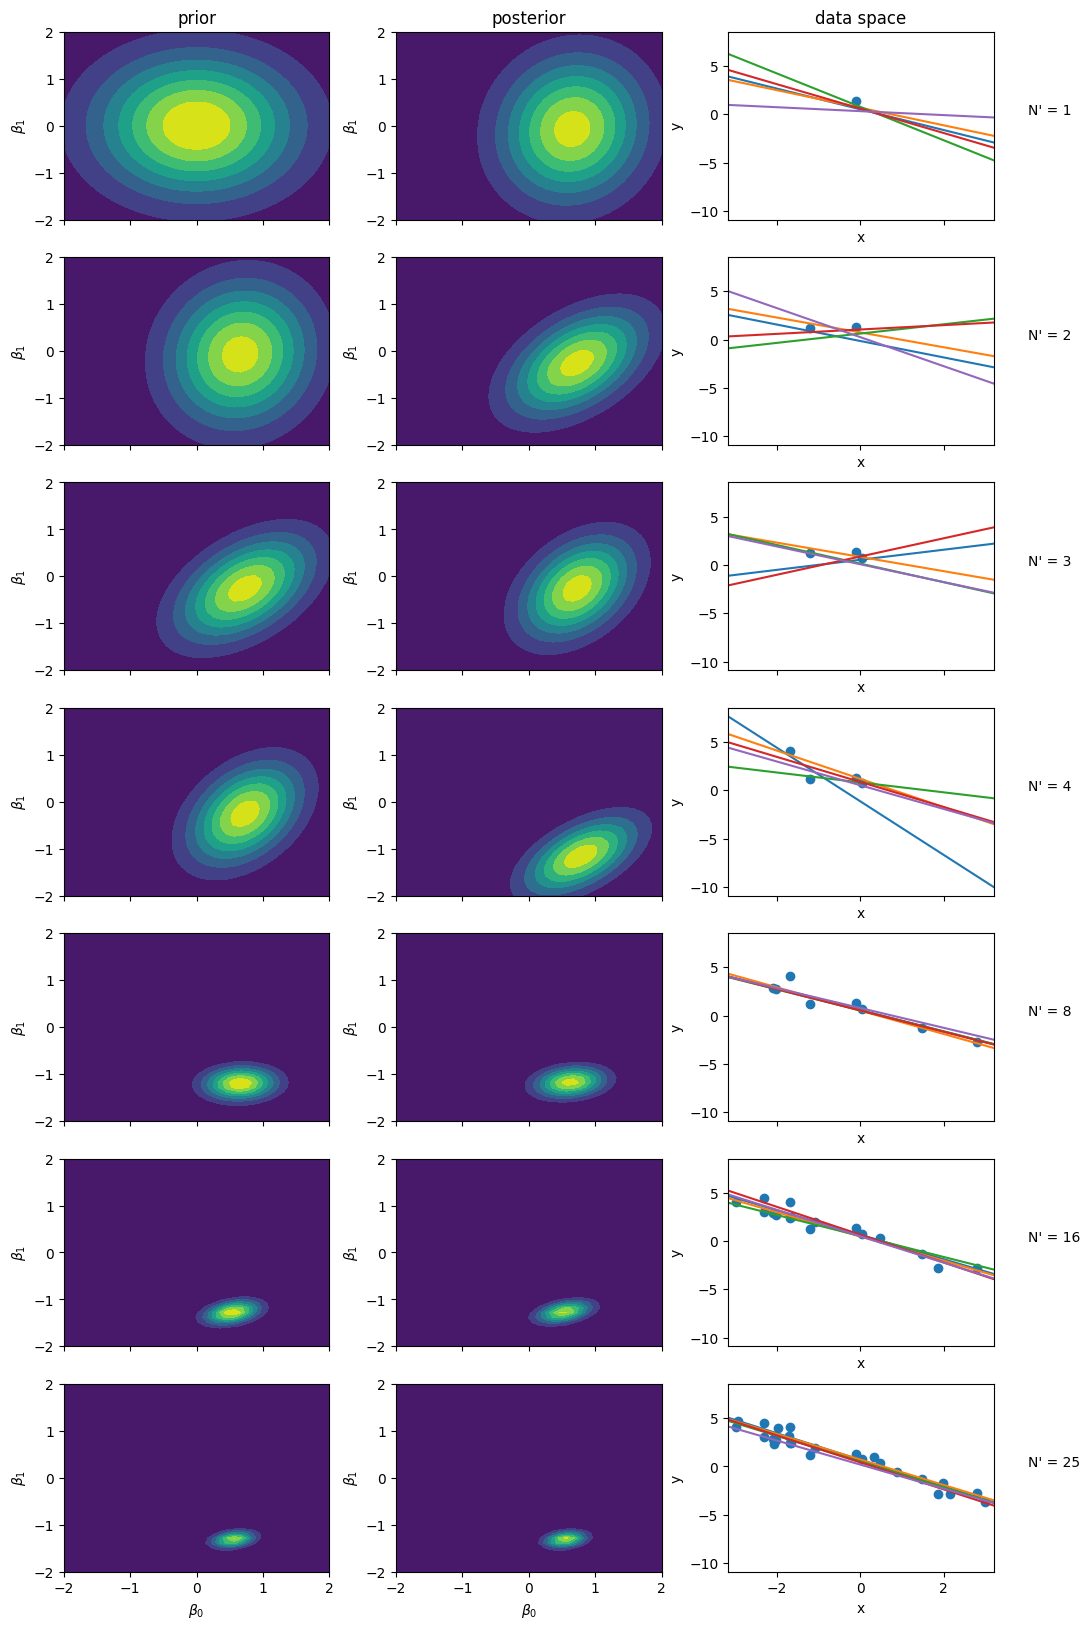

In [32]:
# The values of N_prime that we would like to plot
N_primes = np.array([1, 2, 3, 4, 8, 16, N])

# Creating the figure
fig, axes = plt.subplots(nrows=len(N_primes), ncols=3, sharex="col", sharey="col", figsize=(12,20))
fig.subplots_adjust(wspace=.25)
titles = ["prior", "posterior", "data space"]   # titles of the columns
x_range = np.linspace(min(X)-0.2, max(X)+0.2)   # x-coordinates for the linear functions is data space column
n_samples = 5     # number of linear functions plotted in data space column
for i, N_prime in enumerate(N_primes):
    
    # select the first N_prime data points
    X_temp = X[:N_prime]
    Y_temp = Y[:N_prime]
    # compute the parameters of prior based on the first N_prime - 1 datapoints
    mu_prior, S_prior = compute_parameters(X_temp[:-1], Y_temp[:-1])
    # compute the parameters of posterior based on the first N_prime datapoints
    mu_post, S_post = compute_parameters(X_temp, Y_temp)
    
    for j in range(3):
        
        # plot the priors
        if j == 0:
            contour_plot_bivariate_Gaussian(axes[i,j], mu_prior, S_prior)
        # plot the posteriors
        if j == 1:
            contour_plot_bivariate_Gaussian(axes[i,j], mu_post, S_post)
        
        if j == 2:
            # plot the data
            axes[i, j].scatter(X_temp, Y_temp)
            
            X_range = get_columns_of_ones(x_range)
            # plot a sample of fits based on parameters drawn from the posterior
            for k in range(n_samples):
                axes[i, j].plot(x_range, X_range @ np.random.multivariate_normal(mu_post, S_post))
        
        # layout and axes of the plots
        if i == 0:
            axes[i, j].set_title(titles[j])
        if j == 2:
            axes[i, j].text(4, 0, "N' = {}".format(N_prime))
        if i == len(N_primes)-1 and j<2:
            axes[i, j].set_xlabel(r"$\beta_0$")
        if j < 2:
            axes[i, j].set_ylabel(r"$\beta_1$")
            axes[i, j].set_xlim(left=-2, right=2)
            axes[i, j].set_ylim(bottom=-2, top=2)
        if j == 2:
            axes[i, j].set_xlabel("x")
            axes[i, j].set_ylabel("y")
            axes[i, j].set_xlim(left=min(X)-0.2, right=max(X)+0.2)

## Part 2: classification using LDA and logistic regression
In this part of the assignment, we will apply different classification methods to the `moons` data generating process of scikit-learn, which is imported and visualized in the cell below.

Hint: you may use/copy material of the computer classes (including the solutions) freely and without penalty.

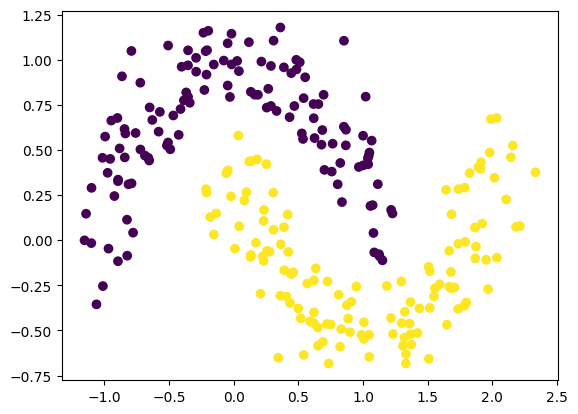

In [33]:
# DO NOT CHANGE THIS CELL!!! #
X_moons, y_moons = datasets.make_moons(n_samples = 256, noise = .15)
plt.scatter(X_moons[:,0], X_moons[:,1], c=y_moons);

**Exercise 3:** use Linear Discriminant Analysis (LDA) to determine the prediction regions, based on the classification dataset given by `X_moons` and `y_moons`. Your solution should consist of two parts:
* implementation of the method (i.e., writing a training function that trains a model using this method and returns a predictor function).
* visualization of the prediction regions.

Note: your are **not** allowed to use any training methods/functions from existing packages or modules.

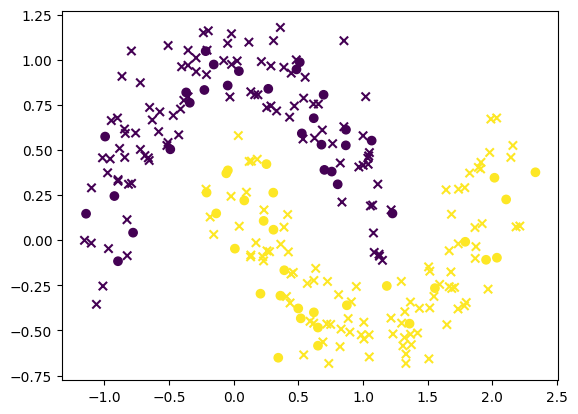

In [34]:
choosen = np.random.choice(256, 200, replace=False)
X_train = X_moons[choosen]
y_train = y_moons[choosen]
X_test = np.delete(X_moons, choosen, axis=0)
y_test = np.delete(y_moons, choosen)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, marker='x')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, marker='o')

### 2.1 Inefficent LDA implementation
This version uses the inverse when training

In [35]:
def train_lda(X: np.ndarray, y: np.ndarray):
    classes = np.unique(y)
    pi_hats = np.array([np.mean(y == c) for c in classes])
    mu_hats = np.array([np.mean(X[y == c], axis=0) for c in classes])
    
    def _inner_sum(k: int):
        return np.sum([np.outer(x - mu_hats[k], x - mu_hats[k]) for x in X[y == k]], axis=0)

    sigma_hat = np.sum([_inner_sum(k) for k in classes], axis=0) /( len(X) - len(classes))
    sigma_hat_inverse = np.linalg.inv(sigma_hat)


    def delta_k(x: np.ndarray, k: int) -> float:
        return (-1/2) * (x - mu_hats[k]).T @ sigma_hat_inverse @ (x - mu_hats[k]) + np.log(pi_hats[k])

    def predictor(x: np.ndarray) -> np.ndarray:
        return np.array([np.argmax([delta_k(x_i, k) for k in classes]) for x_i in x])
    return predictor, delta_k

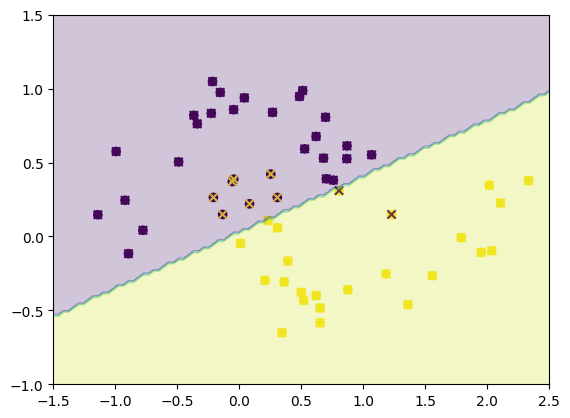

In [36]:
lda_predictor, delta_k = train_lda(X_train, y_train)

# Plot the test data and their predictions
plt.scatter(X_test[:,0], X_test[:,1], c=lda_predictor(X_test), marker='o')
# Plot the test data and their true labels as x
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, marker='x')

# Plot the decision boundary
x_range = np.linspace(-1.5, 2.5, 100)
y_range = np.linspace(-1, 1.5, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
classes = lda_predictor(np.c_[x_grid.ravel(), y_grid.ravel()])
plt.contourf(x_grid, y_grid, classes.reshape(x_grid.shape), alpha=0.25)

### 2.2 Efficent LDA implementation
This LDA implementatio uses the eigendecomposition to calculate the inverse more efficently

In [37]:
def train_lda_efficent(X: np.ndarray, y: np.ndarray):
    classes = np.unique(y)
    pi_hats = np.array([np.mean(y == c) for c in classes])
    mu_hats = np.array([np.mean(X[y == c], axis=0) for c in classes])

    def _inner_sum(k: int):
        return np.sum(
            [np.outer(x - mu_hats[k], x - mu_hats[k]) for x in X[y == k]], axis=0
        )

    sigma_hat = np.sum([_inner_sum(k) for k in classes], axis=0) / (
        len(X) - len(classes)
    )

    D, U = np.linalg.eigh(sigma_hat)
    D = np.diag(D)
    D_inv = np.diag(np.diag(1 / D))

    def delta_k(x: np.ndarray, k: int) -> float:
        return (-1 / 2) * (
            (U.T @ (x - mu_hats[k])).T @ D_inv @ (U.T @ (x - mu_hats[k]))
        ) + np.log(pi_hats[k])

    def predictor(x: np.ndarray) -> np.ndarray:
        return np.array([np.argmax([delta_k(x_i, k) for k in classes]) for x_i in x])

    return predictor, delta_k


C:\Users\Albin\AppData\Local\Temp\ipykernel_86036\190129826.py:17: RuntimeWarning: divide by zero encountered in divide
  D_inv = np.diag(np.diag(1 / D))


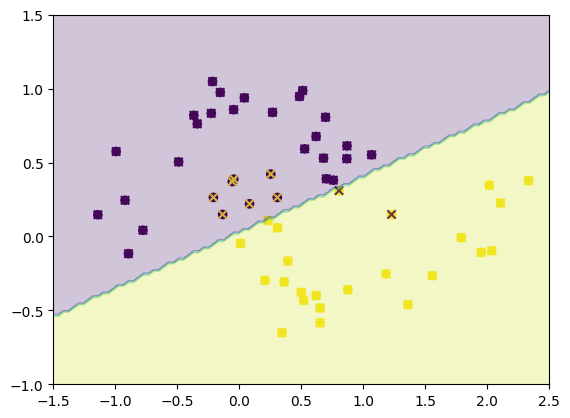

In [38]:
lda_predictor, delta_k = train_lda_efficent(X_train, y_train)

# Plot the test data and their predictions
plt.scatter(X_test[:,0], X_test[:,1], c=lda_predictor(X_test), marker='o')
# Plot the test data and their true labels as x
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, marker='x')

# Plot the decision boundary
x_range = np.linspace(-1.5, 2.5, 100)
y_range = np.linspace(-1, 1.5, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
classes = lda_predictor(np.c_[x_grid.ravel(), y_grid.ravel()])
plt.contourf(x_grid, y_grid, classes.reshape(x_grid.shape), alpha=0.25)

**Exercise 4:** in the above exercise, we see that LDA performs poorly on this dataset. However, with some small adjustments one can get a much better prediction accuracy. Repeat all the three steps of the previous exercise, but now for LDA with an increased feature space. Choose your derived features smartly.

Note: your are **not** allowed to use any training methods/functions from existing packages or modules.

In [39]:
# Given that the data looks like it could be seperated by a polynomial of degree 3, we will transform the data
# and train the LDA on the transformed data.
# We only transform the data on one axis, since that should be enough to seperate the data.
def transform_x(X: np.ndarray) -> np.ndarray:
    return np.c_[X, X[:,0]**2, X[:,0]**3]

C:\Users\Albin\AppData\Local\Temp\ipykernel_86036\190129826.py:17: RuntimeWarning: divide by zero encountered in divide
  D_inv = np.diag(np.diag(1 / D))


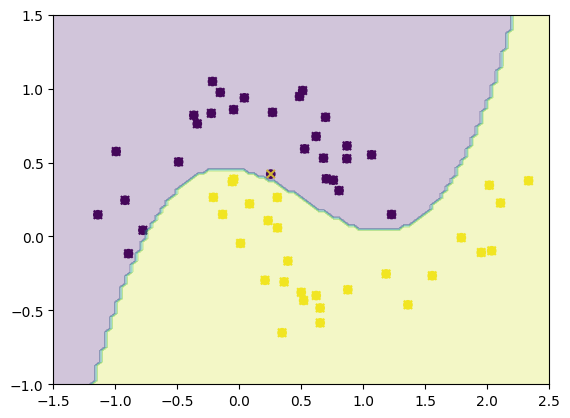

In [40]:
X_train_transformed, X_test_transformed = transform_x(X_train), transform_x(X_test)
lda_predictor, delta_k = train_lda_efficent(X_train_transformed, y_train)

# Plot the test data and their predictions
plt.scatter(X_test[:,0], X_test[:,1], c=lda_predictor(X_test_transformed), marker='o')
# Plot the test data and their true labels as x
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, marker='x')
x_range = np.linspace(-1.5, 2.5, 100)
y_range = np.linspace(-1, 1.5, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
x_grid_transformed = transform_x(np.c_[x_grid.ravel(), y_grid.ravel()])
classes = lda_predictor(x_grid_transformed)
plt.contourf(x_grid, y_grid, classes.reshape(x_grid.shape), alpha=0.25)

**Exercise 5:** repeat the previous two exercises, but now for logistic regression instead of LDA.

Note: your are **not** allowed to use any training methods/functions from existing packages or modules.

In [41]:
def stochastic_gradient_decent_with_momentum(
    X: np.ndarray,
    y: np.ndarray,
    learning_rate: float = 0.01,
    n_iter: int = 1000,
    mini_batch_size: int = 32,
    alpha: float = 0.9,
    lambda_: float = 0.01,
):
    X = get_columns_of_ones(X)
    beta = np.random.rand(X.shape[1])
    momentum = np.zeros(X.shape[1])

    def forward(X: np.ndarray) -> np.ndarray:
        calc = X @ beta
        # Apply sigmoid function
        return 1 / (1 + np.exp(-calc))

    for _ in range(n_iter):
        # Calculate gradient
        mini_batch = np.random.randint(0, len(X), mini_batch_size)
        mini_batch_X = X[mini_batch]
        mini_batch_y = y[mini_batch]
        gradient = -np.sum(
            np.array(
                [
                    x_n * (mini_batch_y[n] - np.exp(beta @ x_n) / (1 + np.exp(beta @ x_n)))
                    for n, x_n in enumerate(mini_batch_X)
                ]
            ),
            axis=0,
        )
        gradient += lambda_ * np.sign(beta)
        momentum = alpha * momentum - learning_rate * gradient
        beta += momentum

    def predictor(X: np.ndarray) -> np.ndarray:
        X = get_columns_of_ones(X)
        return forward(X) > 0.5

    return predictor, beta

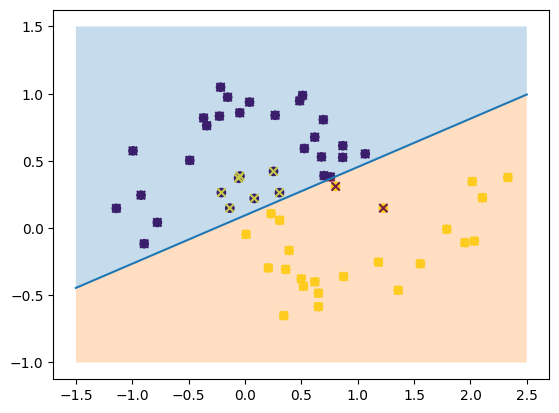

In [42]:
pred, beta= stochastic_gradient_decent_with_momentum(X_train, y_train)
plt.scatter(X_test[:,0], X_test[:,1], c=pred(X_test), marker='o')
# Plot the test data and their true labels as x
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, marker='x')
# Plot the decision based on the beta values
x_range = np.linspace(-1.5, 2.5, 100)
plt.plot(x_range, (-beta[0] - beta[1] * x_range) / beta[2])
# Fill the area above the decision boundary
plt.fill_between(x_range, (-beta[0] - beta[1] * x_range) / beta[2], 1.5, alpha=0.25)
# Fill the area below the decision boundary
plt.fill_between(x_range, -1, (-beta[0] - beta[1] * x_range) / beta[2], alpha=0.25)

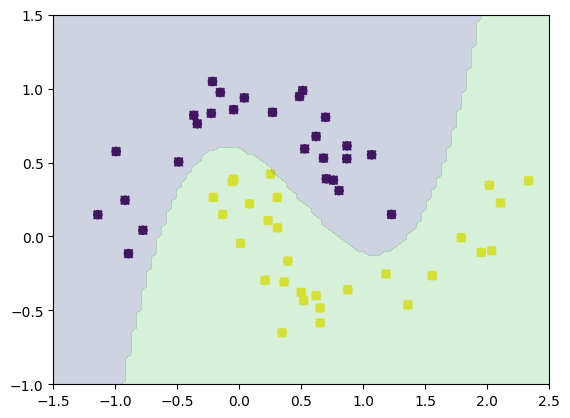

In [43]:
X_train_transformed, X_test_transformed = transform_x(X_train), transform_x(X_test)
pred, beta = stochastic_gradient_decent_with_momentum(X_train_transformed, y_train)
plt.scatter(X_test[:,0], X_test[:,1], c=pred(X_test_transformed), marker='o')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, marker='x')
# Plot the decision boundary
x_range = np.linspace(-1.5, 2.5, 100)
y_range = np.linspace(-1, 1.5, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
x_grid_transformed = transform_x(np.c_[x_grid.ravel(), y_grid.ravel()])
classes = pred(x_grid_transformed)
plt.contourf(x_grid, y_grid, classes.reshape(x_grid.shape), alpha=0.25)